In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 16,8
import seaborn as sns
from scipy import stats
sns.set()

In [2]:
initial_capital = 180000 # Starting capital
trade_log = pd.read_csv('backtest_results.csv')
trade_log['Entry_Date'] = pd.to_datetime(trade_log['Entry_Date'])

trade_log['portfolio_amount'] = 180000 + trade_log['PnL'].cumsum()                    # Cumulative portfolio amount
trade_log['cum_return %'] = (trade_log['portfolio_amount'] - 180000)*100 / 180000     # Cumulative portfolio returns
trade_log['% return'] = trade_log['cum_return %'].diff()                              # Daily returns
trade_log.loc[0, '% return'] = trade_log['cum_return %'].iloc[0] 


trade_log['cum_banknifty_return'] = (trade_log['BANKNIFTY_open'] - trade_log['BANKNIFTY_open'].iloc[0])*100 / trade_log['BANKNIFTY_open'].iloc[0]   
trade_log['banknifty_return'] = trade_log['cum_banknifty_return'].diff()
trade_log.loc[0, 'banknifty_return'] = trade_log['cum_banknifty_return'].iloc[0]

In [3]:
trade_log.head()

,Unnamed: 0,Entry_Date,BANKNIFTY_open,Days To Expiry,CE_Symbol,CE_Entry_Price,CE_Exit_price,CE_Exit_Time,PE_Symbol,PE_Entry_Price,PE_Exit_price,PE_Exit_Time,PnL,portfolio_amount,cum_return %,% return,cum_banknifty_return,banknifty_return
0,0,2022-01-03,35811.8516,4,BANKNIFTY06JAN2236200CE,138.40,181.15,10:30:00,BANKNIFTY06JAN2235300PE,190.30,48.70,15:15:00,2471.25,182471.25,1.372917,1.372917,0.000000,0.000000
1,1,2022-01-04,36616.6992,3,BANKNIFTY06JAN2237000CE,107.55,144.55,09:17:00,BANKNIFTY06JAN2236200PE,172.20,61.20,15:15:00,1850.00,184321.25,2.400694,1.027778,2.247434,2.247434
2,2,2022-01-05,36982.8008,2,BANKNIFTY06JAN2237200CE,86.90,113.75,09:17:00,BANKNIFTY06JAN2236600PE,118.15,17.25,15:15:00,1851.25,186172.50,3.429167,1.028472,3.269725,1.022292
3,3,2022-01-06,37533.0000,1,BANKNIFTY06JAN2237700CE,73.90,0.35,15:15:00,BANKNIFTY06JAN2237200PE,106.70,139.70,09:17:00,1013.75,187186.25,3.992361,0.563194,4.806086,1.536361
4,4,2022-01-07,37894.8516,7,BANKNIFTY13JAN2238500CE,189.95,259.20,09:30:00,BANKNIFTY13JAN2237300PE,250.00,325.00,12:42:00,-3606.25,183580.00,1.988889,-2.003472,5.816510,1.010424


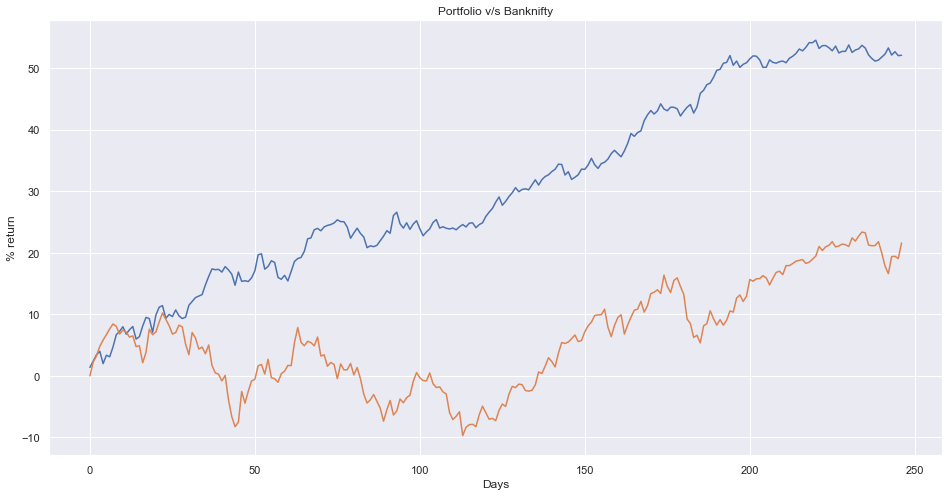

In [4]:
trade_log['cum_return %'].plot()
trade_log['cum_banknifty_return'].plot()
plt.title('Portfolio v/s Banknifty')
plt.ylabel('% return')
plt.xlabel('Days')
plt.show()

<AxesSubplot:>

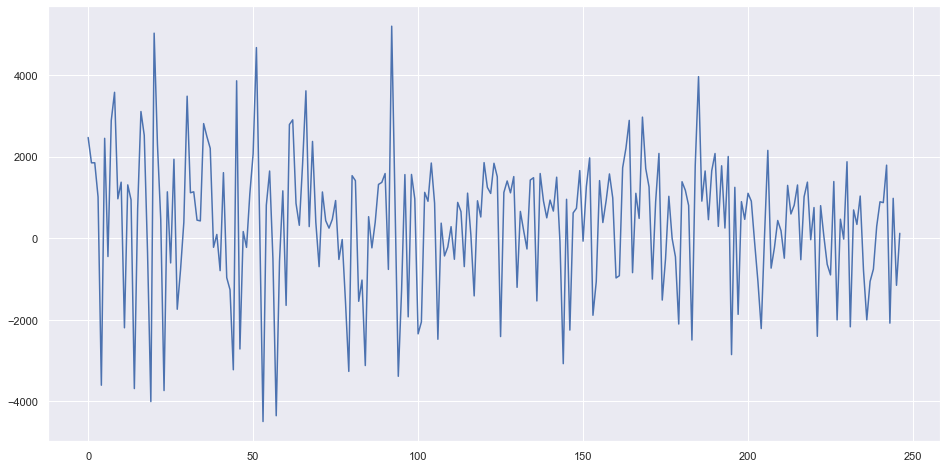

In [5]:
trade_log.PnL.plot()

In [6]:
stats.describe(trade_log['% return'])

DescribeResult(nobs=247, minmax=(-2.49861111111111, 2.8902777777777757), mean=0.2108721322537112, variance=0.8603972192208592, skewness=-0.37848346465156935, kurtosis=0.5591388355339069)

In [7]:
n, minmax, mean, var, skew, kurt = stats.describe(trade_log['% return'])
std = var**0.5
x = stats.norm.rvs(mean, std, n)

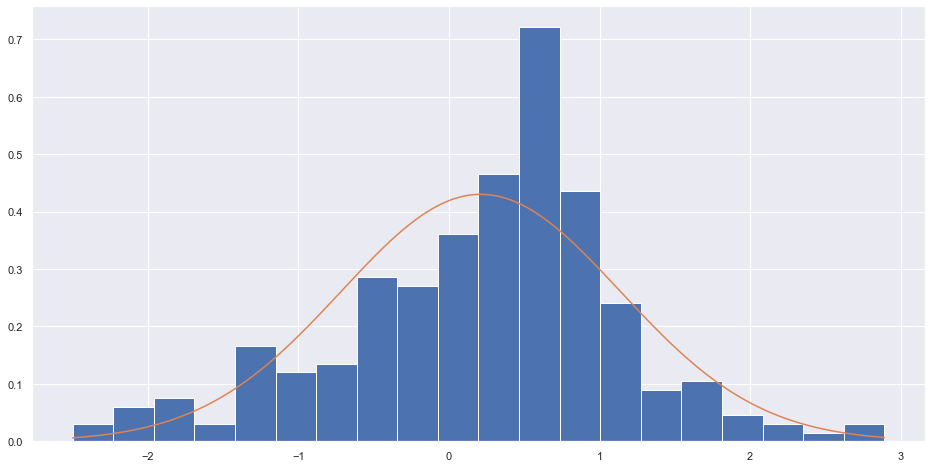

In [8]:
plt.hist(trade_log['% return'], bins=20, density=True)
overlay = np.linspace(minmax[0], minmax[1], 252)
plt.plot(overlay, stats.norm.pdf(overlay, mean, std))

### Conclusion :
Daily returns close to a normal distribution with skewness=-0.378 and excess kurtosis=0.56

<AxesSubplot:>

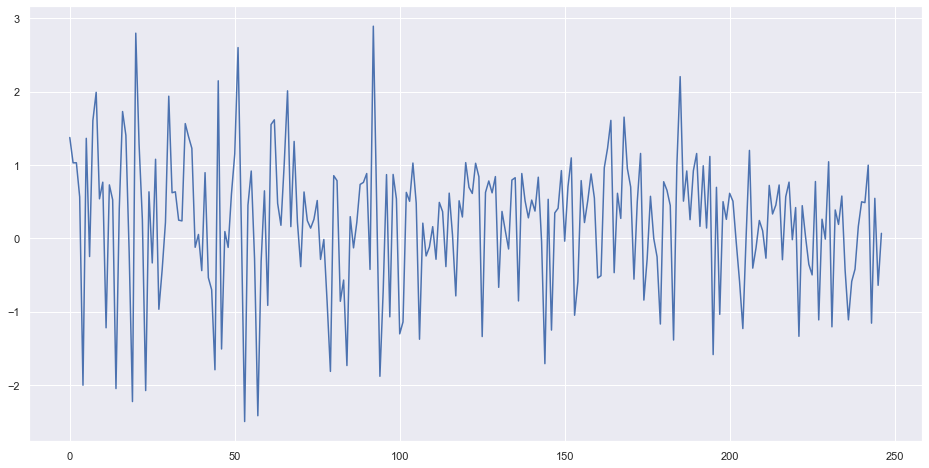

In [9]:
trade_log['% return'].plot()

In [10]:
class TradeAnalyzer:
    def __init__(self, trade_log, initial_capital):
        self.trade_log = trade_log
        self.initial_capital = initial_capital
        self.years = trade_log['Entry_Date'].nunique() / 252 
    
    def compute_cagr(self):
        cagr = ((self.trade_log['portfolio_amount'].iloc[-1] / self.initial_capital) ** (1/self.years) - 1) * 100
        return cagr
    
    def compute_sharpe(self):
        daily_returns = self.trade_log['% return'] / 100
        risk_free_rate = 0.065/252
        sharpe_ratio = (np.mean(daily_returns - risk_free_rate) / np.std(daily_returns)) * np.sqrt(252)
        return sharpe_ratio
    
    def compute_sortino(self):
        daily_returns = self.trade_log['% return'] / 100
        downside_returns = np.where(daily_returns < 0, daily_returns, 0)
        downside_std = np.std(downside_returns) * np.sqrt(252)
        risk_free_rate = 0.065/252
        sortino_ratio = (np.mean(daily_returns - risk_free_rate) / downside_std)
        return sortino_ratio
    
    def compute_drawdown(self):
        portfolio_value = self.trade_log['portfolio_amount']
        peak = portfolio_value.cummax()
        drawdown = (portfolio_value - peak) / peak
        max_drawdown_percent = np.min(drawdown) * 100
        max_drawdown_value = np.min(portfolio_value - peak)
        return max_drawdown_percent, max_drawdown_value
    
    def compute_monthly_returns(self):
        trade_log = self.trade_log.copy()
        trade_log['YearMonth'] = trade_log['Entry_Date'].dt.to_period('M')
        monthly_returns = trade_log.groupby('YearMonth')['% return'].sum()
        return monthly_returns
    
    def consecutive_win_loss(self):
        consecutive_wins = 0
        max_consecutive_wins = 0
        consecutive_losses = 0
        max_consecutive_losses = 0

        for ret in self.trade_log['% return']:
            if ret > 0:
                consecutive_wins += 1
                max_consecutive_wins = max(max_consecutive_wins, consecutive_wins)
                consecutive_losses = 0
            elif ret < 0:
                consecutive_losses += 1
                max_consecutive_losses = max(max_consecutive_losses, consecutive_losses)
                consecutive_wins = 0
            else:
                consecutive_wins = 0
                consecutive_losses = 0

        return max_consecutive_wins, max_consecutive_losses
    
    def compute_total_returns(self):
        total_returns = self.trade_log['% return'].sum()
        return total_returns
    
    def compute_win_rate(self):
        win_rate = (self.trade_log['% return'] > 0).mean() * 100
        return win_rate
    
    def compute_calmar_ratio(self):
        cagr = self.compute_cagr()
        max_drawdown_percent, max_drawdown_value = self.compute_drawdown()
        calmar_ratio = cagr / abs(max_drawdown_percent)
        return calmar_ratio

In [11]:
trade_analyzer = TradeAnalyzer(trade_log, initial_capital)

cagr = trade_analyzer.compute_cagr()
print("CAGR: {:.2f}%\n".format(cagr))

sharpe_ratio = trade_analyzer.compute_sharpe()
print("Sharpe Ratio: {:.2f}\n".format(sharpe_ratio))

sortino_ratio = trade_analyzer.compute_sortino()
print("Sortino Ratio: {:.2f}\n".format(sortino_ratio))

max_drawdown_percent, max_drawdown_value = trade_analyzer.compute_drawdown()
print("Max Drawdown: {:.2f}%".format(max_drawdown_percent))
print("Max Drawdown Value: {:.2f}\n".format(max_drawdown_value))

monthly_returns = trade_analyzer.compute_monthly_returns()
print("Monthly Returns:")
print(monthly_returns)
print()

consecutive_wins, consecutive_losses = trade_analyzer.consecutive_win_loss()
print("Consecutive Wins: {}".format(consecutive_wins))
print("Consecutive Losses: {}\n".format(consecutive_losses))

total_returns = trade_analyzer.compute_total_returns()
print("Total Returns: {:.2f}%\n".format(total_returns))

win_rate = trade_analyzer.compute_win_rate()
print("Win Rate: {:.2f}%\n".format(win_rate))

calmar_ratio = trade_analyzer.compute_calmar_ratio()
print("Calmar Ratio: {:.2f}\n".format(calmar_ratio))


CAGR: 53.38%

Sharpe Ratio: 3.17

Sortino Ratio: 0.02

Max Drawdown: -3.68%
Max Drawdown Value: -8138.75

Monthly Returns:
YearMonth
2022-01     7.084028
2022-02    10.220139
2022-03    -1.882639
2022-04     6.936111
2022-05     1.546528
2022-06     3.298611
2022-07     7.141667
2022-08     3.434028
2022-09     8.111806
2022-10     5.450694
2022-11     1.964583
2022-12    -1.220139
Freq: M, Name: % return, dtype: float64

Consecutive Wins: 11
Consecutive Losses: 4

Total Returns: 52.09%

Win Rate: 65.59%

Calmar Ratio: 14.50

